In this module, we build 2 models and assess their perforance to see which signal is best

In [2]:
import os, sys
import pandas as pd 
import numpy as np
import requests 
from datetime import datetime, date, time, timedelta
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from mpl_finance import candlestick_ohlc
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.ticker as mticker
%load_ext autoreload
%matplotlib inline

## Extract Y= Difference betwen High and Open at Pump Hour

In [3]:
p = pd.read_pickle('../pump_data_with_social.pkl')
print(p.columns.values)

['channelLink' 'channelTitle' 'currency' 'duration' 'exchange'
 'priceBeforePump' 'signalTime' 'pumptime_edited' 'timestamp'
 'pump_weekday' 'pump_date' 'pump_hour' 'pump_minute' 'pump_hour_0'
 'open_0' 'high_0' 'low_0' 'close_0' 'volumeto_0' 'pump_hour_1' 'open_1'
 'high_1' 'low_1' 'close_1' 'volumeto_1' 'pump_hour_2' 'open_2' 'high_2'
 'low_2' 'close_2' 'volumeto_2' 'pump_hour_3' 'open_3' 'high_3' 'low_3'
 'close_3' 'volumeto_3' 'pump_hour_4' 'open_4' 'high_4' 'low_4' 'close_4'
 'volumeto_4' 'pump_hour_5' 'open_5' 'high_5' 'low_5' 'close_5'
 'volumeto_5' 'pump_hour_6' 'open_6' 'high_6' 'low_6' 'close_6'
 'volumeto_6' 'pump_day_1' 'open_day_1' 'high_day_1' 'low_day_1'
 'close_day_1' 'volumeto_day_1' 'pump_day_2' 'open_day_2' 'high_day_2'
 'low_day_2' 'close_day_2' 'volumeto_day_2' 'pump_day_3' 'open_day_3'
 'high_day_3' 'low_day_3' 'close_day_3' 'volumeto_day_3' 'pump_day_4'
 'open_day_4' 'high_day_4' 'low_day_4' 'close_day_4' 'volumeto_day_4'
 'pump_day_5' 'open_day_5' 'high_day_5' '

In [8]:
trade_vars = p.filter(regex='open|close|high|low|volumeto_').columns.values

##  Convert to Satoshi
...Since the values of coins in BTC is so small, we convert them into a Satoshi = 1E-8 a Bitcoin

In [9]:
#Test conversion
p.open_0[2]*1E8

2928.0

In [10]:
#Employ the concept of smooting: we add 1 if the value is too small!!!
for var in trade_vars:
    p[var] = p[var].apply(lambda x: x*1e8 if x >= 1e-10 else x*1e8 + 1)

In [11]:
p[trade_vars].head(3)

,open_0,high_0,low_0,close_0,volumeto_0,open_1,high_1,low_1,close_1,volumeto_1,...,followers_6,twitter_followers_6,twitter_following_6,code_repo_closed_issues_7,code_repo_closed_pull_issues_7,code_repo_open_issues_7,code_repo_open_pull_issues_7,followers_7,twitter_followers_7,twitter_following_7
0,1158.0,1158.0,1120.0,1132.0,6.195000e+08,1111.0,1191.0,1101.0,1158.0,241100000.0,...,7.460000e+10,5.406400e+12,2.540000e+10,1.0,1.0,100000000.0,1.0,7.460000e+10,5.406400e+12,2.540000e+10
1,1269.0,1478.0,1223.0,1257.0,1.028900e+10,1223.0,1280.0,1207.0,1269.0,793400000.0,...,7.430000e+10,5.416600e+12,2.540000e+10,1.0,1.0,100000000.0,1.0,7.430000e+10,5.416800e+12,2.540000e+10
2,2928.0,3060.0,2917.0,2927.0,1.519000e+09,2940.0,2952.0,2920.0,2928.0,237100000.0,...,7.410000e+10,5.478200e+12,2.530000e+10,1.0,1.0,100000000.0,1.0,7.410000e+10,5.478200e+12,2.530000e+10


In [12]:
p['pump_increase'] = p.high_0 - p.open_0
p['pump_increase_percent'] = round((p.pump_increase / p.open_0) * 100,0)

In [13]:
important_vars = ['channelTitle','currency','exchange','timestamp','pumptime_edited'
       ,'open_0','high_0','low_0','close_0','volumeto_0'
        ,'open_1','high_1','low_1','close_1','volumeto_1'
       ,'pump_increase','pump_increase_percent'] 
p[important_vars].head(3)

,channelTitle,currency,exchange,timestamp,pumptime_edited,open_0,high_0,low_0,close_0,volumeto_0,open_1,high_1,low_1,close_1,volumeto_1,pump_increase,pump_increase_percent
0,Crypto Pump Island,ADX,Binance,1564163999,2019-07-26 17:59:59+00:00,1158.0,1158.0,1120.0,1132.0,6.195000e+08,1111.0,1191.0,1101.0,1158.0,241100000.0,0.0,0.0
1,Signal Kingdom,ADX,Binance,1562346032,2019-07-05 17:00:32+00:00,1269.0,1478.0,1223.0,1257.0,1.028900e+10,1223.0,1280.0,1207.0,1269.0,793400000.0,209.0,16.0
2,Maximum Pump,ADX,Binance,1556219721,2019-04-25 19:15:21+00:00,2928.0,3060.0,2917.0,2927.0,1.519000e+09,2940.0,2952.0,2920.0,2928.0,237100000.0,132.0,5.0


Where v_0 is NOT greater than v_1

In [14]:
p.loc[p.volumeto_0 <= p.volumeto_1][important_vars].sample(3)
# p.loc[p.volumeto_0 <= p.volumeto_1][important_vars].shape

,channelTitle,currency,exchange,timestamp,pumptime_edited,open_0,high_0,low_0,close_0,volumeto_0,open_1,high_1,low_1,close_1,volumeto_1,pump_increase,pump_increase_percent
314,Bull ⚡️ Signals,CTXC,Yobit,1553283018,2019-03-22 19:30:18+00:00,3275.0,3275.0,3275.0,3275.0,1.000000e+00,3255.0,3275.0,3255.0,3275.0,1.592000e+07,0.0,0.0
144,Bitcoin Pump Group,NEO,Binance,1563965694,2019-07-24 10:54:54+00:00,118200.0,118400.0,117500.0,117900.0,1.538000e+09,115200.0,119800.0,115200.0,118200.0,1.408500e+10,200.0,0.0
135,Bitcoin Pump Group,NULS,Binance,1564130413,2019-07-26 08:40:13+00:00,5753.0,5753.0,5753.0,5753.0,1.000000e+00,5753.0,5753.0,5753.0,5753.0,1.000000e+00,0.0,0.0


In [15]:
p.pump_increase_percent.describe()

count     426.00000
mean       49.27230
std       105.91853
min         0.00000
25%         1.00000
50%         7.00000
75%        51.00000
max      1322.00000
Name: pump_increase_percent, dtype: float64

Take a look at the distribition of pump's level of pump inflation

In [ ]:
# t = pd.DataFrame(p.groupby('pump_increase_percent').pump_increase_percent.count())
# t.head(10)

## REVISE THE GOAL:
We extend the range of data to be 2 hours from pump_hour_0 to pump_hour_1 and use the range of increase as whatever is the lowest opening price of the prevous hour and the highest of the pump hour.

In [16]:
p = p.drop(['pump_increase','pump_increase_percent'],axis=1)

In [17]:
p['pump_increase'] = p[['open_1','high_0','high_1']].apply(func=lambda x: max(x[1],x[2]) - x[0],axis=1)
p['pump_increase_percent'] = round((p.pump_increase / p.open_1) * 100,0)

In [18]:
p.loc[p.volumeto_0 <= p.volumeto_1][important_vars].sample(3)

,channelTitle,currency,exchange,timestamp,pumptime_edited,open_0,high_0,low_0,close_0,volumeto_0,open_1,high_1,low_1,close_1,volumeto_1,pump_increase,pump_increase_percent
108,Yobit Pumping Crazy Community™,BNT,Yobit,1546102820,2018-12-29 17:00:20+00:00,15000.0,17850.0,14000.0,17850.0,4.327000e+07,16000.0,17000.0,15000.0,15000.0,6.605000e+07,1850.0,12.0
3,Bitcoin Pump Group,WAN,Binance,1567183290,2019-08-30 16:41:30+00:00,3935.0,4120.0,3864.0,3918.0,1.619800e+10,3958.0,4066.0,3781.0,3935.0,2.543000e+10,162.0,4.0
84,⚜️Heavy Pumps⚜️,QKC,Yobit,1564945203,2019-08-04 19:00:03+00:00,226.0,243.0,153.0,156.0,2.768000e+05,146.0,227.0,135.0,226.0,2.974000e+05,97.0,66.0


In [19]:
p.pump_increase_percent.describe()

count      426.000000
mean       144.424883
std       1855.206884
min          0.000000
25%          4.000000
50%         13.000000
75%         67.750000
max      38300.000000
Name: pump_increase_percent, dtype: float64

In [20]:
x = pd.DataFrame(p.groupby('pump_increase_percent').pump_increase_percent.count())
x = x.rename(columns={'pump_increase_percent':'count'})
x['pump_increase_prct'] = x.index
x = x.reset_index(drop=True)
x.head()

,count,pump_increase_prct
0,50,0.0
1,18,1.0
2,14,2.0
3,9,3.0
4,20,4.0


# SOME QUESTIONS TO PONDER
- Should we actualy only extract the hours and not the minutes adjustment?
- How should we break the bins of y values?

In [21]:
def convertPercentIncrasetoCat(x:float, scheme:int = 3):
    '''
        Based on the distribution of the percentage increase breakdown the categories
        Break them so that they are as equally binned as possible.
        param: x float value of the percentage increase in price
    '''
    if scheme == 1: 
        if x == 0.0:
            return 0
        elif 0.0 < x <= 5.0: 
            return 1
        elif 5.0 < x <= 10.0: 
            return 2
        elif 10.0 < x <= 25.0:
            return 3 
        elif 25.0 < x <= 100.0:
            return 4 
#         elif 75.0 < x <= 200.0: 
#             return 5 
        elif 100 < x: 
            return 5
        else:
            return 6
    elif scheme == 2: 
        #Scheme 2
        if x == 0.0:
            return 0
        elif 0.0 < x <= 50.0: 
            return 1
        elif 50.0 < x <= 100.0: 
            return 2
        elif 100.0 < x <= 300.0:
            return 3 
        else: 
            return 4
    elif scheme == 3:
        if  0.0 <= x <= 5.0:
            return 0
        elif 5.0 < x <= 15.0: 
            return 1
        elif 15.0 < x <= 75.0:
            return 2
        elif x > 75: 
            return 3

In [22]:
p['pump_increase_cat'] = p.pump_increase_percent.apply(lambda x : convertPercentIncrasetoCat(x,scheme=3))

In [23]:
p[important_vars + ['pump_increase_cat']].head(3)

,channelTitle,currency,exchange,timestamp,pumptime_edited,open_0,high_0,low_0,close_0,volumeto_0,open_1,high_1,low_1,close_1,volumeto_1,pump_increase,pump_increase_percent,pump_increase_cat
0,Crypto Pump Island,ADX,Binance,1564163999,2019-07-26 17:59:59+00:00,1158.0,1158.0,1120.0,1132.0,6.195000e+08,1111.0,1191.0,1101.0,1158.0,241100000.0,80.0,7.0,1
1,Signal Kingdom,ADX,Binance,1562346032,2019-07-05 17:00:32+00:00,1269.0,1478.0,1223.0,1257.0,1.028900e+10,1223.0,1280.0,1207.0,1269.0,793400000.0,255.0,21.0,2
2,Maximum Pump,ADX,Binance,1556219721,2019-04-25 19:15:21+00:00,2928.0,3060.0,2917.0,2927.0,1.519000e+09,2940.0,2952.0,2920.0,2928.0,237100000.0,120.0,4.0,0


(array([121.,   0.,   0., 104.,   0.,   0., 102.,   0.,   0.,  99.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

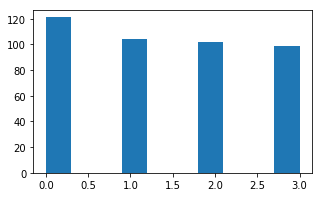

In [24]:
fig = plt.figure(figsize=(5,3))
plt.hist(p.pump_increase_cat)

In [25]:
p.to_pickle('pump_data_with_y.pkl')

## RANDOM FOREST MODEL 
Now that we have the independent variable, __pump_increase_cat__, we can use the features variables to build a simple logistic regression model.

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
time_features = ['pump_weekday','pump_date','pump_hour','pump_minute']
pump_hour_features = ['high_0', 'low_0', 'close_0', 'volumeto_0','analysis_page_views_0', 'charts_page_views_0',
                    'markets_page_views_0', 'overview_page_views_0',
                    'total_page_views_0', 'trades_page_views_0']
market_features = ['open_0', 'high_0', 'low_0', 'close_0', 'volumeto_0', 'open_1',
       'high_1', 'low_1', 'close_1', 'volumeto_1', 'open_2', 'high_2',
       'low_2', 'close_2', 'volumeto_2', 'open_3', 'high_3', 'low_3',
       'close_3', 'volumeto_3', 'open_4', 'high_4', 'low_4', 'close_4',
       'volumeto_4', 'open_5', 'high_5', 'low_5', 'close_5', 'volumeto_5',
       'open_6', 'high_6', 'low_6', 'close_6', 'volumeto_6', 'open_day_1',
       'high_day_1', 'low_day_1', 'close_day_1', 'volumeto_day_1',
       'open_day_2', 'high_day_2', 'low_day_2', 'close_day_2',
       'volumeto_day_2', 'open_day_3', 'high_day_3', 'low_day_3',
       'close_day_3', 'volumeto_day_3', 'open_day_4', 'high_day_4',
       'low_day_4', 'close_day_4', 'volumeto_day_4', 'open_day_5',
       'high_day_5', 'low_day_5', 'close_day_5', 'volumeto_day_5',
       'open_day_6', 'high_day_6', 'low_day_6', 'close_day_6',
       'volumeto_day_6', 'open_day_7', 'high_day_7', 'low_day_7',
       'close_day_7']
chart_features = ['analysis_page_views_0', 'charts_page_views_0',
                'markets_page_views_0', 'overview_page_views_0',
                'total_page_views_0', 'trades_page_views_0',
                'analysis_page_views_1', 'charts_page_views_1',
                'markets_page_views_1', 'overview_page_views_1',
                'total_page_views_1', 'trades_page_views_1',
                'analysis_page_views_2', 'charts_page_views_2',
                'markets_page_views_2', 'overview_page_views_2',
                'total_page_views_2', 'trades_page_views_2',
                'analysis_page_views_3', 'charts_page_views_3',
                'markets_page_views_3', 'overview_page_views_3',
                'total_page_views_3', 'trades_page_views_3',
                'analysis_page_views_4', 'charts_page_views_4',
                'markets_page_views_4', 'overview_page_views_4',
                'total_page_views_4', 'trades_page_views_4',
                'analysis_page_views_5', 'charts_page_views_5',
                'markets_page_views_5', 'overview_page_views_5',
                'total_page_views_5', 'trades_page_views_5',
                'analysis_page_views_6', 'charts_page_views_6',
                'markets_page_views_6', 'overview_page_views_6',
                'total_page_views_6', 'trades_page_views_6']

In [25]:
features = time_features + market_features + chart_features
print("BEFORE pruning pump_hour variables: {} features".format(len(features)))
features_past = list(set(features) - set(pump_hour_features))
features_past = np.sort(features_past)
print("AFTER pruning pump_hour variables: {} features".format(len(features_past)))

BEFORE pruning pump_hour variables: 115 features
AFTER pruning pump_hour variables: 105 features


In [26]:
X = p[features_past].values
y = p['pump_increase_cat'].values

In [27]:
p[p.pump_increase_cat.isnull()]

,channelLink,channelTitle,currency,duration,exchange,priceBeforePump,signalTime,pumptime_edited,timestamp,pump_weekday,...,trades_page_views_6,analysis_page_views_7,charts_page_views_7,markets_page_views_7,overview_page_views_7,total_page_views_7,trades_page_views_7,pump_increase,pump_increase_percent,pump_increase_cat


In [28]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

## SCALE/Standardize the dataset

In [29]:
std = StandardScaler()

In [30]:
x_train_std = std.fit_transform(x_train)
x_test_std = std.transform(x_test)

## SCALE/Min-Max Scaler

In [31]:
mima = MinMaxScaler()

In [32]:
x_train_mima = mima.fit_transform(x_train)
x_test_mima = mima.transform(x_test)

In [33]:
print("The number of features in this scaled set: ",x_train_mima.shape)

The number of features in this scaled set:  (340, 105)


...Test for irregularities

In [34]:
np.isnan(y_train).any()

False

In [35]:
# y_train

## Random Forest Model

In [36]:
rfc = RandomForestClassifier(random_state=10)

In [37]:
param_grid = {'n_estimators': [200,500,750]
             ,'max_features': ['auto','sqrt','log2']
             ,'max_depth': [5,10,15]
             ,'criterion': ['gini','entropy']}

In [38]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10)
CV_rfc.fit(x_train_mima,y_train)

/Users/AdrianTran/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 500, 750], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 10, 15], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 750}

## Use the best parameters to train the model again 

In [40]:
rfc_best = RandomForestClassifier(criterion='entropy',max_depth= 5, max_features='auto',n_estimators=750)

In [41]:
rfc_best.fit(x_train_mima,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
rfc_pred = rfc_best.predict(x_test_mima)

In [43]:
accuracy_score(y_test, rfc_pred)

0.46511627906976744

In [44]:
# Try another test set for Verification
sample_index = np.random.randint(low=0,high=X.shape[1],size=100)
x_test_2 = X[sample_index]
y_test_2 = y[sample_index]
x_test_2_std = mima.transform(x_test_2)
rfc_pred2 =  rfc_best.predict(x_test_2_std)

In [45]:
accuracy_score(y_test_2,rfc_pred2)

0.7

## Assessing Variable Importance

In [46]:
rf_features = pd.DataFrame(rfc_best.feature_importances_.reshape(1,-1), columns=features_past).T
rf_features['features'] = rf_features.index
rf_features = rf_features.reset_index(drop=True)
rf_features.columns = ['importance','features']


In [47]:
rf_features.sort_values('importance', inplace=True,ascending=False)
rf_features['rank'] = range(1,rf_features.shape[0]+1)
rf_features.to_pickle('rf_feature_importance.pkl')
rf_features.head()

,importance,features,rank
102,0.055659,volumeto_day_4,1
104,0.054427,volumeto_day_6,2
99,0.051707,volumeto_day_1,3
101,0.047624,volumeto_day_3,4
103,0.045009,volumeto_day_5,5


Text(0.5, 0, 'Random Forest Feature Importance')

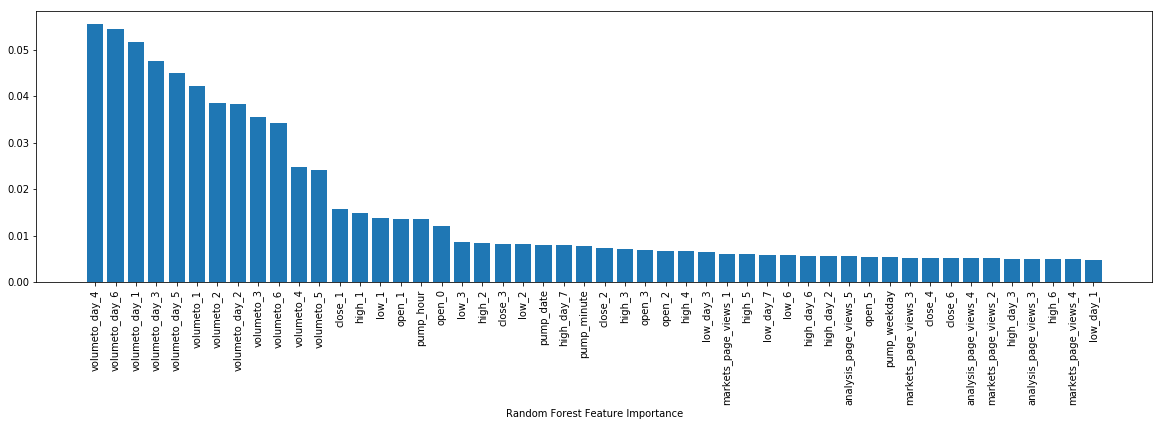

In [48]:
fig = plt.figure(figsize=(20,5))
plt.bar(height=rf_features.importance[:50], x=rf_features.features[:50])
plt.xticks(rf_features.features[:50],  rotation='vertical')
plt.xlabel('Random Forest Feature Importance')

## Perform Cross Validation

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [50]:
minmax_scaler = MinMaxScaler()
#Reuse the best parameters determined above
clf = RandomForestClassifier(criterion='entropy',max_depth= 10, max_features='auto',n_estimators=750)

In [51]:
k = 10
pipeline = Pipeline([('transformer',minmax_scaler),('estimator',clf)])
cv = KFold(n_splits=k)

In [52]:
cv_output = cross_val_score(pipeline,X,y,cv=cv)

In [74]:
print("Average Accuracy for Randrom Forest {}-Fold Validation {}".format(k,np.average(cv_output)))

Average Accuracy for Randrom Forest 10-Fold Validation 0.4582502768549281


## Multinomial Logistic Regression

In [56]:
lr = LogisticRegressionCV(multi_class='multinomial', random_state=10,solver="newton-cg",cv=5)

### Train the paremeters for best ones

In [90]:
lr_best = LogisticRegressionCV(multi_class='multinomial', random_state=10,solver="newton-cg",cv=5)

In [91]:
lr_best.fit(x_train_mima, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=None, penalty='l2',
           random_state=10, refit=True, scoring=None, solver='newton-cg',
           tol=0.0001, verbose=0)

In [92]:
lr_best_pred = lr_best.predict(x_test_mima)

In [93]:
accuracy_score(y_test, lr_best_pred)

0.4883720930232558

### K-Cross Validation

In [94]:
k = 10
lr_clf = LogisticRegressionCV(multi_class='multinomial', random_state=10,solver="newton-cg", Cs=10,cv=5)
lr_pipeline= Pipeline([('transformer',minmax_scaler),('estimator',lr_clf)])
cv = KFold(n_splits=k)

In [95]:
lr_cv_output = cross_val_score(lr_pipeline,X,y,cv=cv)

In [96]:
print("Average Accuracy for Logistic Regression {}-Fold Validation {}".format(k,np.average(lr_cv_output)))

Average Accuracy for Logistic Regression 10-Fold Validation 0.43172757475083057


### Feature Importance

In [127]:
lr_coefs = np.average(lr_best.coef_, axis=0)
# lr_coefs = np.sort(lr_coefs)
# lr_coefs = np.flip(lr_coefs)
lr_coefs.shape

(105,)

In [150]:
lr_weights = pd.DataFrame(lr_coefs).T
lr_weights.columns =  features_past
lr_weights = lr_weights.T
lr_weights['features'] =  lr_weights.index
lr_weights = lr_weights.reset_index(drop=True)
lr_weights.columns = ['coef','features']
lr_weights['coef_abs'] = abs(lr_weights.coef)

In [151]:
lr_weights.sort_values('coef_abs',ascending=False,inplace=True)

Text(0.5, 0, 'Multinomial Logistic Regression Feature Importance')

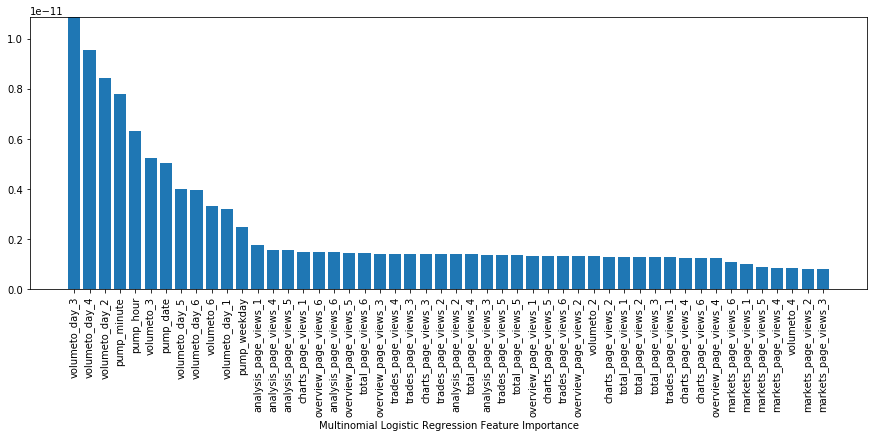

In [164]:
fig = plt.figure(figsize=(15,5))
plt.bar(height=lr_weights.coef_abs[:50], x=lr_weights.features[:50])
plt.xticks(lr_weights.features[:50],  rotation='vertical')
plt.xlabel('Multinomial Logistic Regression Feature Importance')

## XG Boost Model

In [156]:
from xgboost import XGBClassifier
from xgboost import DMatrix

In [157]:
xg = XGBClassifier(objective='multi:softmax',num_class=7)

In [158]:
xg_param_grid = {"max_depth":[5,10,15]
                ,"n_estimators":[100,500,750]
                ,"min_child_weight":[1,3,5]}

### Search for best parameters

In [159]:
xg_grid_cv = GridSearchCV(estimator=xg,param_grid=xg_param_grid,cv=10)
xg_grid_cv.fit(x_train_mima,y_train)

/Users/AdrianTran/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_class=7,
       objective='multi:softmax', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 15], 'n_estimators': [100, 500, 750], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [160]:
xg_grid_cv.best_params_

{'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 100}

### Train on scaled data

In [215]:
xg_best = XGBClassifier(objective='multi:softmax',num_class=4, max_depth=15, n_estimators=100,min_child_weight=1)
xg_best.fit(x_train_mima,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_class=4,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [216]:
xg_pred = xg_best.predict(x_test_mima)

In [217]:
accuracy_score(y_test,xg_pred)

0.47674418604651164

### Feature Importance
Note that there are many types of features importance in XGBoost. 
__Quoted__:https://datascience.stackexchange.com/questions/12318/how-to-interpret-the-output-of-xgboost-importance

The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

The Cover metric means the relative number of observations related to this feature. For example, if you have 100 observations, 4 features and 3 trees, and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17 observations. This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features' cover metrics.

The Frequency (/'Frequence') is the percentage representing the relative number of times a particular feature occurs in the trees of the model. In the above example, if feature1 occurred in 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3; then the weightage for feature1 will be 2+1+3 = 6. The frequency for feature1 is calculated as its percentage weight over weights of all features.

Text(0.5, 0, 'XG feature Importance by WEIGHT')

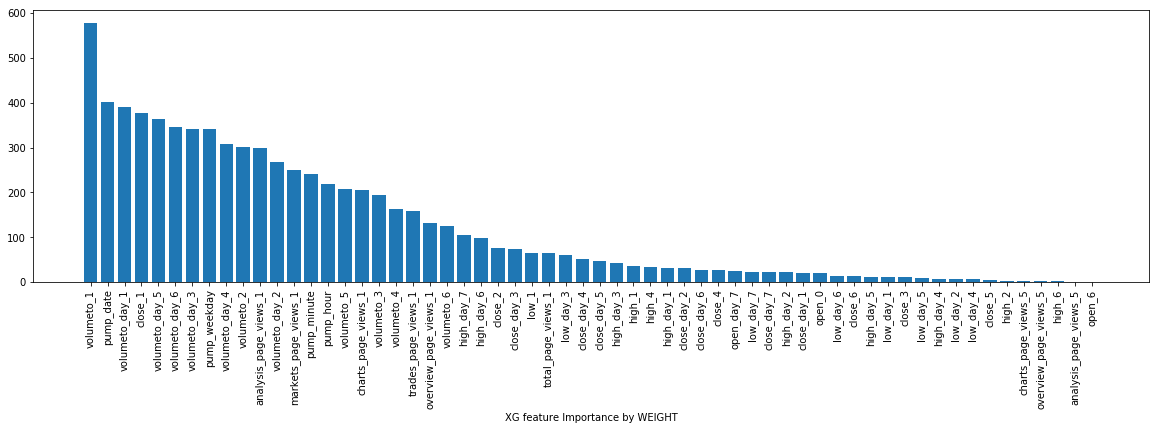

In [218]:
#This is IMPORTANCE explicitly by Weight
xg_weight = pd.DataFrame(xg_best.get_booster().get_fscore(), index=[0]).T
xg_weight['weight_norm'] = xg_weight/np.sum(xg_weight[0])
xg_weight['index_orig'] = xg_weight.index
xg_weight['index_orig'] = xg_weight.index_orig.apply(lambda x:int(x[1:]))
xg_weight.sort_values('index_orig',inplace=True)
xg_weight =  pd.merge(left=xg_weight,left_on='index_orig',right=pd.DataFrame(features_past),right_index=True,how='left')
xg_weight.reset_index(drop=True) 
xg_weight.columns = ['fscore','weight_norm','index_orig','feature']
xg_weight.sort_values('fscore',ascending=False,inplace=True)
fig = plt.figure(figsize=(20,5))
plt.bar(x=xg_weight.feature,height=xg_weight.fscore)
plt.xticks(xg_weight.feature, rotation='vertical')
plt.xlabel('XG feature Importance by WEIGHT')

In [219]:
xg_features = pd.DataFrame(xg_best.feature_importances_.reshape(-1,1), columns=['xg_importance'])
xg_features['xg_features'] = features_past

In [220]:
xg_features.sort_values('xg_importance',inplace=True, ascending=False)
xg_features.head()
xg_features['rank'] = range(1,xg_features.shape[0]+1)
xg_features.to_pickle('xg_feature_importance.pkl')

In [221]:
xg_features[xg_features['rank'] <= 5]

,xg_importance,xg_features,rank
101,0.065179,volumeto_day_3,1
98,0.060551,volumeto_6,2
12,0.037673,close_1,3
28,0.037069,high_4,4
23,0.030794,close_day_6,5


Text(0.5, 0, 'XGBOOST Feature Importance by GAIN')

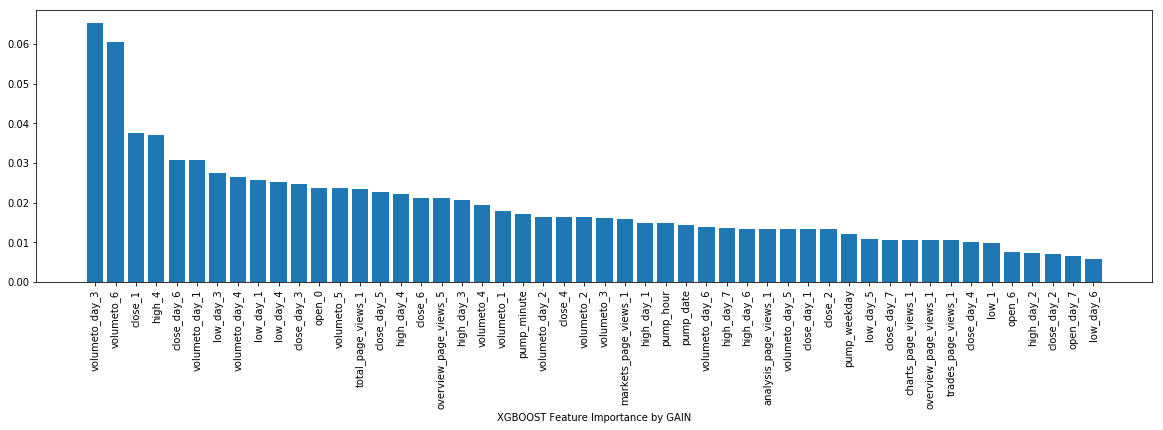

In [222]:
fig = plt.figure(figsize=(20,5))
plt.bar(x=xg_features.xg_features[:50], height=xg_features.xg_importance[:50])
plt.xticks(xg_features.xg_features[:50], rotation='vertical')
plt.xlabel('XGBOOST Feature Importance by GAIN')

In [ ]:
#For reference only
# fig = xgboost.plot_importance(xg_best, importance_type='weight')
# plt.rcParams['figure.figsize'] = [20, 15]
# plt.show()

### K-cross Validation

In [249]:
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()
xg_clf = XGBClassifier(objective='multi:softmax',num_class=4, max_depth=15, 
                       n_estimators=100,min_child_weight=1)

In [250]:
k = 10
xg_pipe = Pipeline([('transformer',minmax_scaler),('estimator',xg_clf)])
xg_cv = KFold(n_splits=k)

In [251]:
xg_cv_output = cross_val_score(xg_pipe,X,y,cv=cv)

In [252]:
print("Average Accuracy for {}-Fold Validation {}".format(k,np.average(xg_cv_output)))

Average Accuracy for 10-Fold Validation 0.49086378737541525


## KNN Neighbors

In [234]:
from sklearn.neighbors import KNeighborsClassifier

In [235]:
knn = KNeighborsClassifier()

In [236]:
knn_grid_search = {"n_neighbors":[5,10,15,20]} 

In [237]:
knn_cv = GridSearchCV(estimator=knn, param_grid=knn_grid_search)
knn_cv.fit(x_train_mima, y_train)

/Users/AdrianTran/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

/Users/AdrianTran/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [238]:
knn_cv.best_params_

{'n_neighbors': 20}

In [239]:
knn_best = KNeighborsClassifier(n_neighbors=20)
knn_best.fit(x_train_mima,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform')

In [240]:
knn_pred = knn_best.predict(x_test_std)

In [241]:
accuracy_score(y_test, knn_pred)

0.4418604651162791

### K-Cross Validation

In [242]:
k=10
knn_clf = KNeighborsClassifier(n_neighbors=20)
knn_pipeline = Pipeline([('transformer',minmax_scaler),('estimator',knn_clf)])
cv = KFold(n_splits=k)

In [243]:
knn_cv_output = cross_val_score(knn_pipeline,X,y,cv=cv)

In [244]:
print("Average Accuracy for KNN {}-Fold Validation {}".format(k,np.average(knn_cv_output)))

Average Accuracy for KNN 10-Fold Validation 0.3171650055370986
